<a href="https://colab.research.google.com/github/Rami-RK/HugingFace_Transformers/blob/main/Hf_Fine_Tunning_BERT_Custom_Data_Set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Huggingface: Fine Tunning BERT using Custom Data Set**

### Objectives:

At the end of the experiment you will be able to understand  :

* How to load & convert any custom dataset into a HF datasets
* Trainer and trainingArguments objects
* Computing Metrics
* Saving and loading the trained model

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers datasets

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

### **Loading the Custom Data**

In [ ]:
df_ = pd.read_csv('/content/Tweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df_[['airline_sentiment', 'text']].copy()
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

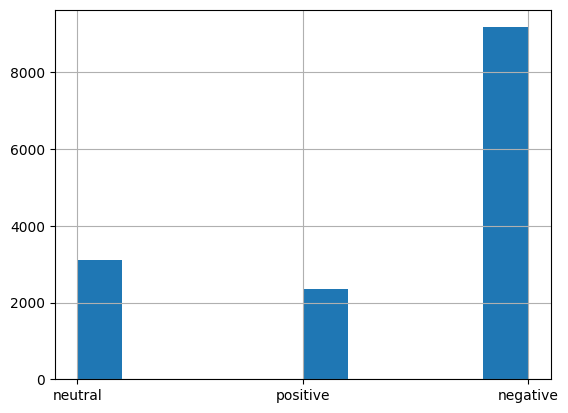

In [ ]:
df['airline_sentiment'].hist()

In [ ]:
target_map ={'positive':1, 'negative':0, 'neutral':2}
df['target'] = df['airline_sentiment'].map(target_map)

In [ ]:
df2 = df[['text','target']]
df2.columns=['sentence','label']
df2.to_csv('data.csv',index=None)

In [ ]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


### **Finally conveting the data.csv into HF dataset**

In [ ]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [ ]:
split = raw_dataset['train'].train_test_split(test_size = 0.3, seed=42)

In [ ]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [ ]:
# for multiple csv files
# load_dataset('csv', data_files =['file1.csv', 'file2.csv'])

In [ ]:
# if you already have a train-test split :
# load_dataset('csv', data_files ={'train':['train1.csv','train2.csv'],'test':'test.csv'})

### **Tokenizing**

In [ ]:
checkpoint = 'distilbert-base-cased'

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'],truncation = True)

In [ ]:
tokenized_datasets = split.map(tokenize_fn,  batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

### **Defining Model**

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

### **Training Arguments**

In [ ]:
training_args = TrainingArguments(
    output_dir = 'training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size =16,
    per_device_eval_batch_size = 64,
)

### **Metrics**

In [ ]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions =np.argmax(logits,axis=-1)
  acc=np.mean(predictions == labels)
  f1=f1_score(labels,predictions, average='macro')
  return {'accuracy':acc, 'f1':f1}

### **Training**

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["test"],
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.542600,0.427731,0.826047,0.762263
2,0.354200,0.501131,0.832195,0.767617
3,0.227300,0.620860,0.836293,0.783382


TrainOutput(global_step=1923, training_loss=0.3256800190830875, metrics={'train_runtime': 214.1069, 'train_samples_per_second': 143.592, 'train_steps_per_second': 8.981, 'total_flos': 387616869956304.0, 'train_loss': 0.3256800190830875, 'epoch': 3.0})

### **Loading the saved model**

In [ ]:
!ls training_dir

checkpoint-1282  checkpoint-197  checkpoint-591  runs
checkpoint-1923  checkpoint-394  checkpoint-641


In [ ]:
from transformers import pipeline

In [ ]:
my_model = pipeline('text-classification',model='training_dir/checkpoint-591',device=0)

In [ ]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

### **Testing**

In [ ]:
test_pred = my_model(split['test']['sentence'])

In [ ]:
def get_label(d):
  return int(d['label'].split('_')[1])
test_pred =[get_label(d) for d in test_pred]

In [ ]:
print("accuracy : ", accuracy_score(split['test']['label'], test_pred))

accuracy :  0.8497267759562842
